# Product Recommendation Engine Based on Visual Similarity

Author: **Marcin Sikorski**<br>
Date: March, 2023

**Introduction**<br>
In modern times, almost all big tech companies (Google, Netflix, Spotify, Meta) and e-commerce platforms (Allegro, Zalando, Amazon) depend on recommendation systems for giving users recommendations based on their watch lists. Deep learning is a very trendy topic now, showing high accuracy in image based systems that can go from image segmentation to item detection and image retrieval. This type of software provides tons of profits for corporations and save funds in marketing. For example, Netflix consumers thanks to company’s recommender system spend more time watching movies and series. Users also get benefits and advice while browsing on retail websites.

The subject of this repository is to develop a very basic recommender engine for fashion products. For this case, the system should recommend goods that look similar. The idea behind is very simple: if a customer is showing interest towards a specific product by browsing its page, he may also be interested by products that are visually alike. We will implement CNNs with an image feature extraction approach, with <code>Keras</code> and <code>TensorFlow</code> packages.

**Keywords:** deep learning, image based search, e-commerce image retrieval, ResNet50, VGG16, convolutional neural network.

**Data Source**<br>
The data for this notebook is originated from [Kaggle](https://www.kaggle.com/datasets/olgabelitskaya/style-color-images). The main dataset contains 2184 color images (150, 150, 3) with 7 brands and 10 product types according to attached CSV and TXT files.

**Notebook Content:**
1. Dataset Investigation<br>
2. Visualizing Folder Content<br>
3. Pre-Trained Models<br>
4. Feature Extracting With Example<br>
5. Image Similarity Calculation<br>
6. ResNet50<br>
7. VGG16<br>
8. Conclusions

### 1. Dataset Investigation

We will start from importing the software libraries and exploring the dataset. The images are sorted by brands and products. All files are in PNG format and the labels are integers.

In [18]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [19]:
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.image import imread
# set path to data: base dir + folder_name
images_dir = os.path.join(os.getcwd(), '/content/drive/My Drive/style/')
# display number of images in directory
print('Found {} images'.format(len([images_dir + f for f in os.listdir(images_dir) if '.png' in f])))

Found 1248 images


In [20]:
import pandas as pd

# load CSV file and display first rows
df = pd.read_csv('/content/drive/My Drive/style/style.csv')

# number of products, brands, and types
print('Total number of products: {}'.format(df.shape[0]))
print('Total number of unique brands: {}'.format(df['brand_name'].nunique()))
print('Total number of unique product types: {}'.format(df['product_name'].nunique()))

# display first rows
df.head(100)

Total number of products: 2184
Total number of unique brands: 7
Total number of unique product types: 10


,brand_name,brand_label,product_name,product_label,file
0,Christian Louboutin,0,shoes,0,0_0_001.png
1,Christian Louboutin,0,shoes,0,0_0_002.png
2,Christian Louboutin,0,shoes,0,0_0_003.png
3,Christian Louboutin,0,shoes,0,0_0_004.png
4,Christian Louboutin,0,shoes,0,0_0_005.png
...,...,...,...,...,...
95,Christian Louboutin,0,shoes,0,0_0_096.png
96,Christian Louboutin,0,shoes,0,0_0_097.png
97,Christian Louboutin,0,shoes,0,0_0_098.png
98,Christian Louboutin,0,lipstick,1,0_1_001.png


In [21]:
# display labels for brands and product names described in TXT file
def display_labels():
    from io import StringIO

    with open('/content/drive/My Drive/style/style.txt') as file:
        content = file.readlines()[0:]

    columns = 'col1, col2\n'
    df_list = [columns]

    for line in content:
        if line.strip():
            df_list[-1] += line
        elif df_list[-1] != columns:
            df_list.append(columns)
        else:
            continue

    # list of dataframes
    df_list = [pd.read_table(StringIO(df)) for df in df_list]

    # split first column by separator and update header
    for i, df in enumerate(df_list):

        df_list[i] = df_list[i].iloc[:, 0].str.split(',', expand=True)
        df_list[i].columns = ['object', 'label']

    return df_list

df_list = display_labels()

# brands
df_list[0].set_index('label')

,object
label,
0,Christian Louboutin
1,Chanel
2,Dolce & Gabbana
3,Gucci
4,Christian Dior
5,Versace
6,Yves Saint Laurent


In [22]:
# product names
df_list[1].set_index('label')

,object
label,
0,shoes
1,lipstick
2,handbag
3,nail polish
4,necklace
5,watches
6,ring
7,bracelet
8,boots


The files are named as following:

$$i\_ j\_ 0nm.png$$

where $i$ is the unique brand label in range [0, 6], $j$ is the unique product label in range [0, 9], and $nm$ is the ordinal number.

Lets visualize distributions of variables to have a general view of the dataset.

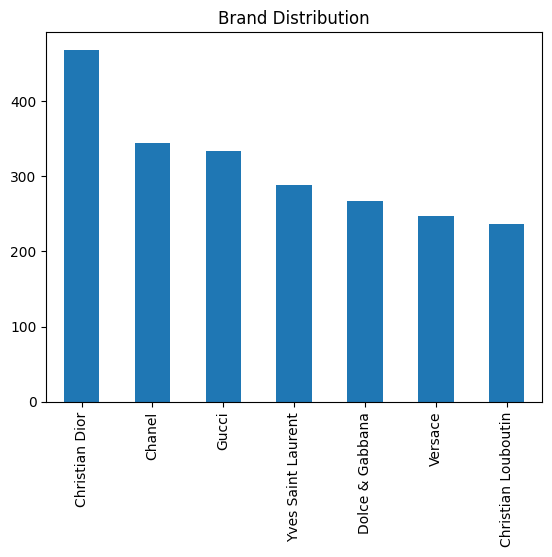

In [7]:
# plot brand distribution
pd.DataFrame(df['brand_name'].value_counts()).plot.bar(title='Brand Distribution', legend=None)
plt.show()

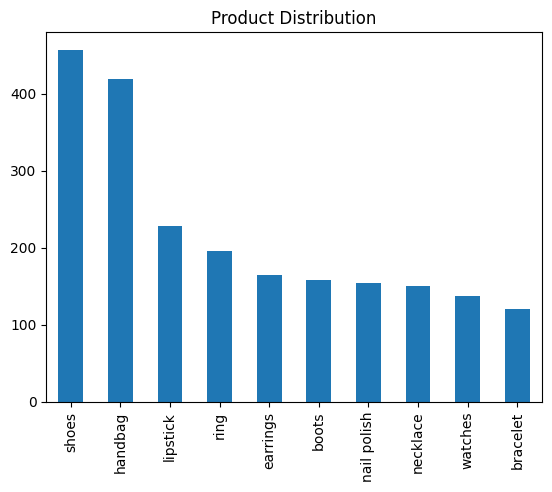

In [8]:
# plot product distribution
pd.DataFrame(df['product_name'].value_counts()).plot.bar(title='Product Distribution', legend=None)
plt.show()

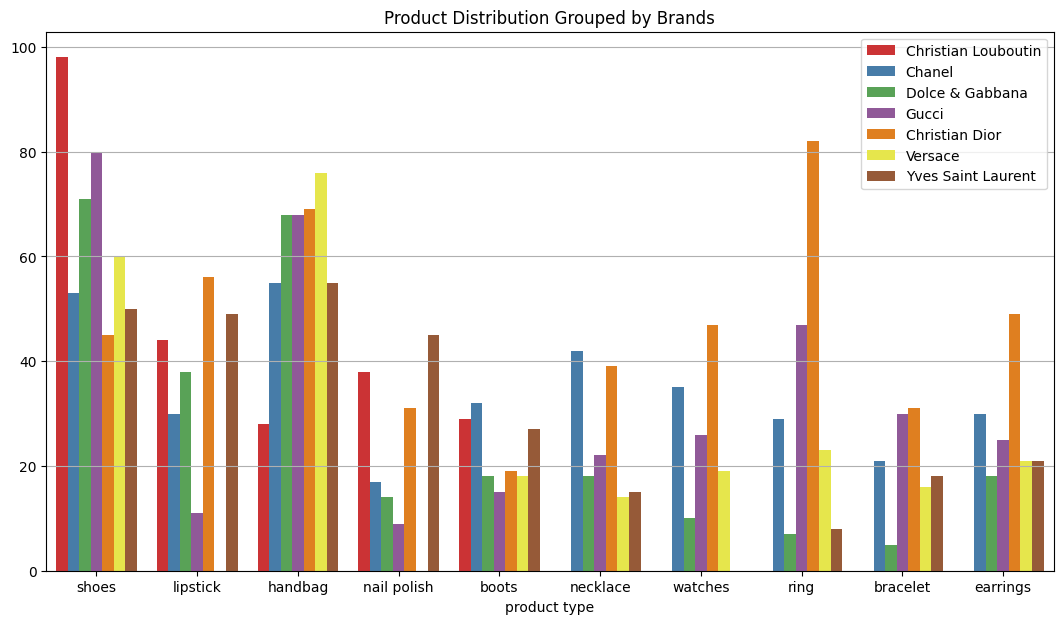

In [9]:
# plot product frequency grouped by brands
def plot_countplot():
    from seaborn import countplot, color_palette

    plt.figure(figsize=(13, 7))
    countplot(data=df, x='product_name', hue='brand_name', palette=color_palette('Set1', n_colors=7))
    plt.title('Product Distribution Grouped by Brands')
    plt.xlabel('product type')
    plt.ylabel(None)
    plt.grid(axis='y')
    plt.legend(loc='best')
    plt.show()

plot_countplot()

### 2. Visualizing Folder Content

Lets display some images from the folder.

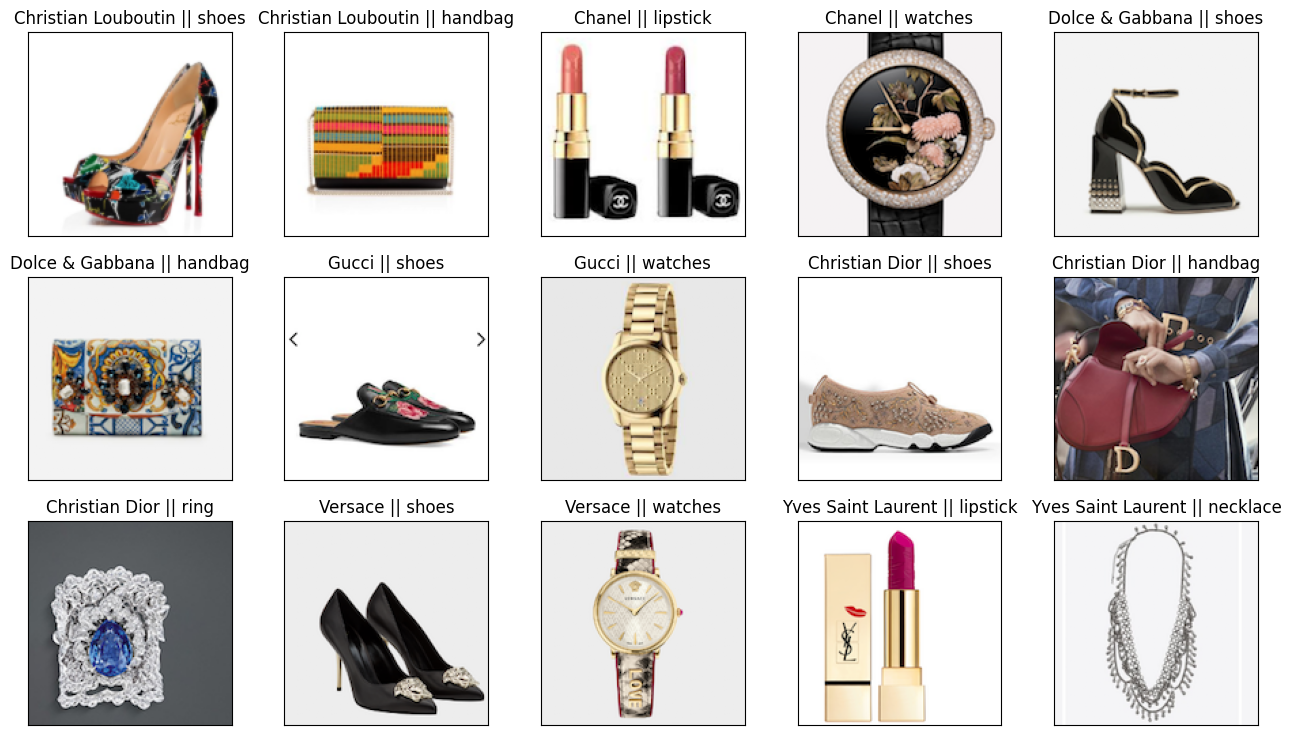

Shape of images: (150, 150)


In [37]:
# display examples of items
def display_images():
    fig = plt.figure(figsize=(16, 9))
    for i in range(15):
      ax = fig.add_subplot(3, 5, i+1, xticks=[], yticks=[])
      img = imread('/content/drive/My Drive/style/' + df['file'][i*150])
      ax.imshow(img, cmap=None)
      ax.set_title('{} || {}'.format(df['brand_name'][i*150], df['product_name'][i*150]))
    plt.show()
    print('Shape of images: ({}, {})'.format(img.shape[0], img.shape[1]))

display_images()

### 3. Pre-Trained Models

We will implement pre-trained models instead of designing new architectures. The <code>Keras</code> module contains several pre-trained models that can be loaded very easily. Such models are already fine-tuned and trained on a huge dataset. This process is known as transfer learning. We will retrieve two convolutional neural networks.

**ResNet** (residual network) has been introduced for the first time in 2015 by Kaiming He, Xiangyu Zhang, Shaoqing Ren, and Jian Sun in their [paper](https://arxiv.org/abs/1512.03385) and let them win the ILSVRC 2015 challenge.

As the VGG authors had already pointed out, the depth of the representation is crucially important. In the case of VGG, deeper networks could be constructed by using smaller convolutional filters. The authors of ResNet used another idea: blocks of a few stacked layers are trained to learn a residual function with respect to the input of the block, instead of learning a general function without reference in the context of the network architecture.

The first **VGGNet** models were created by Karen Simonyan and Andrew Zisserman, and first presented in their [paper](https://arxiv.org/abs/1409.1556) and let them take second place in the the ILSVRC 2014 competition. VGG16 has 16 layers with weights.

Surprisingly enough, the VGG architecture is quite straightforward, conventional, and very similar to the original convolutional networks. The main idea behind VGG was to make the network deeper by stacking more convolutional layers. And this was made possible by restricting the size of the convolutional windows to only 3 x 3 pixels.

The following code will run links and download the ResNet50 and VGG16 models with their weights. The CNNs will be used as our feature extractors.

In [38]:
# select CNN model for feature extracting
def feature_extractor(name):
    """
    Parameters
    ----------
    name : string,
        'resnet50' or 'vgg16'
    """

    from tensorflow.keras.applications.resnet50 import ResNet50
    from tensorflow.keras.applications.vgg16 import VGG16
    from keras.models import Model

    # initiate CNN models
    if (name == 'resnet50'):
        # ResNet50 accepts only (224, 224, 3) image shape
        feat_extractor = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3), pooling='max')

    elif (name == 'vgg16'):
        vgg16 = VGG16(weights='imagenet', include_top=True, input_shape=(224, 224, 3), pooling='max')
        # we don't need all layers of the model and will extract vector from layer 'fc2' as extracted feature of image
        feat_extractor = Model(inputs=vgg16.input, outputs=vgg16.get_layer('fc2').output)

    else:
        raise ValueError('No such model available')

    return feat_extractor

### 4. Feature Extracting With Example

Generally, the product image contains a unique pattern along with its color, shape, and edges. Images with the same kind of such features are supposed to be similar. Therefore, extracting such features from the images will be very helpful in order to recommend the most similar products.

We will perform an example of feature extracting with the ResNet50 model on any picture in the dataset for experimental purposes and check what output the function will return.

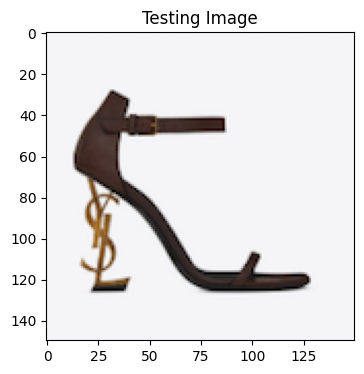

1/1 [==============================] - 2s 2s/step
Image batch size: (1, 224, 224, 3)
Number of extracted features: 2048


In [39]:
# trial function for feature extracting
def test_extract(img_name, feat_extractor):
    """
    Parameters
    ----------
    img_name : string,
        file name with PNG extension
    feat_extractor : keras.engine.functional.Functional
        variable with CNN
    """

    from keras.preprocessing.image import load_img, img_to_array
    from keras.applications.imagenet_utils import preprocess_input

    # load image in PIL format
    original_img = load_img('/content/drive/My Drive/style/' + img_name, target_size=(224, 224))

    # display PIL image
    plt.figure(figsize=(4, 4))
    img = imread('/content/drive/My Drive/style/' + img_name)
    plt.imshow(img, cmap=None)
    plt.title('Testing Image')
    plt.show()

    # convert PIL image into NumPy array
    numpy_img = img_to_array(original_img)

    # convert image into batch format
    # input matrix to the network should be in form: (batchsize, height, width, channels)
    img_batch = np.expand_dims(a=numpy_img, axis=0)

    # prepare image for the ResNet50 model
    processed_img = preprocess_input(img_batch.copy())

    # get the extracted features
    img_features = feat_extractor.predict(processed_img)

    print('Image batch size: {}'.format(img_batch.shape))
    print('Number of extracted features: {}'.format(img_features.size))

# choose ResNet50 for the test
resnet50_mod= feature_extractor(name='resnet50')

# run test on any image
test_extract(img_name='6_0_003.png', feat_extractor=resnet50_mod)

Based on this function we can code a new one to extract features from all PNG files and stack them into an array object.

In [48]:
# extracting features from all images
def extract_features(feat_extractor):
    """
    Parameters
    ----------
    feat_extractor : keras.engine.functional.Functional
        variable with CNN
    """

    from keras.preprocessing.image import load_img, img_to_array
    from keras.applications.imagenet_utils import preprocess_input

    # list of all NumPy images
    imported_images = []

    for img_name in df['file']:
        try:
            original_img = load_img('/content/drive/My Drive/style/' + img_name, target_size=(224, 224))
            numpy_img = img_to_array(original_img)
            img_batch = np.expand_dims(a=numpy_img, axis=0)
            imported_images.append(img_batch)
        except:
            raise ValueError('Some interruption occurred')
            continue

    images = np.vstack(imported_images)
    processed_imgs = preprocess_input(images)

    # get the extracted features
    images_features = feat_extractor.predict(processed_imgs)

    print('Number of processed images: {}'.format(images_features.shape[0]))
    print('Number of extracted features per image: {}'.format(images_features.shape[1]))

    return images_features

### 5. Image Similarity Calculation

To describe any similarities in image retrieval, we need to define image similarity metrics. The idea behind is that by using a distance metric we can evaluate how close two data points are close to each other in the feature space, meaning two vectors that are closely related will have a small difference and a large similarity. We will implement two commonly used distances: cosine and Euclidean. These distance measures are defined as following formulas:

$$s_{cos} = \frac{\sum_{i=1}^d P_i Q_i}{\sqrt{\sum_{i=1}^d P_i^2} \sqrt{\sum_{i=1}^d Q_i^2}}$$

$$d_{Euc} = \sqrt{\sum_{i=1}^d \lvert P_i - Q_i \rvert^2}$$

|    Name   |  Notation |      Type     |                            Description                            |                 Interpretation                 |
|:---------:|:---------:|:-------------:|:-----------------------------------------------------------------:|:----------------------------------------------:|
| cosine    | $s_{cos}$ | similarity    | measures the cosine of the angle<br>between two vector points     | the higher the value the higher the similarity |
| Euclidean | $d_{Euc}$ | dissimilarity | square root of the sum of the<br>squared distances between points | the lower the value the higher the similarity  |

The cosine similarity is in range [0, 1], meaning that 0 stands for completely opposite images and 1 for identicle ones.

An Euclidean distance is in range [0, $+\infty$]. Optionally, we can convert the values into range [0, 1].

In [49]:
# calculate cosine similarities in range: [0, 1], that is: [completely different, identicle]
def cosine_similarity(arr_pred):
    """
    Parameters
    ----------
    arr_pred : numpy.ndarray,
        array with extracted features
    """

    from sklearn.metrics.pairwise import cosine_similarity
    cos_distances = cosine_similarity(arr_pred)

    # convert array into dataframe
    return pd.DataFrame(cos_distances, columns=df['file'], index=df['file'])

# calculate Euclidean distances in range: [0, ∞], that is: [identicle, completely different]
def euclidean_distance(arr_pred):
    """
    Parameters
    ----------
    arr_pred : numpy.ndarray,
        array with extracted features
    """

    from sklearn.metrics import pairwise_distances
    euc_distances = pairwise_distances(arr_pred, metric='euclidean')

    # for range: [0, 1]
    #euc_distances = 1/(1 + pairwise_distances(arr_pred, metric='euclidean'))

    # convert array into dataframe
    return pd.DataFrame(euc_distances, columns=df['file'], index=df['file'])

The final function will plot the input image and return five recommended products. It queries the dataset based on chosen method (<code>distance</code> parameter).

In [54]:
# final function for retrieving most similar products
def retrieve_most_similar_products(given_img, distance):
    """
    Parameters
    ----------
    given_img : string,
        file name with PNG extension
    distance : string,
        'cosine' or 'euclidean'
    """

    ######### display input product to query
    print('='*20, 'Input product:', '='*20)

    # extract brand name and product type from df_list
    brand_name = df_list[0].loc[int(given_img[0]), 'object']
    product_type = df_list[1].loc[int(given_img[2]), 'object']

    img = imread('/content/drive/My Drive/style/' + given_img)
    plt.imshow(img, cmap=None)
    plt.title('{} || {}'.format(brand_name, product_type))
    plt.xticks([]), plt.yticks([])
    plt.show()

    ######### retrieve and display 5 most similar products
    if (distance == 'cosine'):
        cos_similarities_df = cosine_similarity(imgs_features)
        # for 5 products: [1:6]
        closest_imgs = cos_similarities_df[given_img].sort_values(ascending=False)[1:6].index
        closest_imgs_scores = cos_similarities_df[given_img].sort_values(ascending=False)[1:6]

    elif (distance == 'euclidean'):
        euc_distances_df = euclidean_distance(imgs_features)
        # for 5 products: [1:6]
        closest_imgs = euc_distances_df[given_img].sort_values(ascending=True)[1:6].index
        closest_imgs_scores = euc_distances_df[given_img].sort_values(ascending=True)[1:6]

    else:
        print('No such metric defined')

    print('='*20, 'Recommended products:', '='*20)

    fig = plt.figure(figsize=(16, 3))
    for i in range(len(closest_imgs)):
        ax = fig.add_subplot(1, 5, i+1, xticks=[], yticks=[])
        img = imread('/content/drive/My Drive/style/' + closest_imgs[i])
        ax.imshow(img, cmap=None)

        # img title: brand_name + product_name + score
        brand_name = df_list[0].loc[int(closest_imgs[i][0]), 'object']
        product_type = df_list[1].loc[int(closest_imgs[i][2]), 'object']

        if (distance == 'cosine'):
            ax.set_title('{} || {}\nSimilarity score: {:.2f}%'.format(brand_name, product_type,
                                                                      closest_imgs_scores[i]*100))

        elif (distance == 'euclidean'):
            ax.set_title('{} || {}\nEuclidean distance: {:.2f}'.format(brand_name, product_type, closest_imgs_scores[i]))
    plt.show()

### 6. ResNet50

All our functions are ready to run. We will perform first product recommendation on ResNet50 model using cosine scores and Euclidean distances.

In [55]:
# retrieve ResNet50 and rename
resnet_mod = feature_extractor(name='resnet50')
resnet_mod._name = 'ResNet50'

# display the network's architecture
resnet_mod.summary()

# get number of layers in the feature extractor
print('\nNumber of layers:', len(resnet_mod.layers))

Model: "ResNet50"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_7 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_7[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                       

In [56]:
# extract features with ResNet50
imgs_features = extract_features(resnet50_mod)

69/69 [==============================] - 479s 7s/step
Number of processed images: 2184
Number of extracted features per image: 2048


==================== Input product: ====================


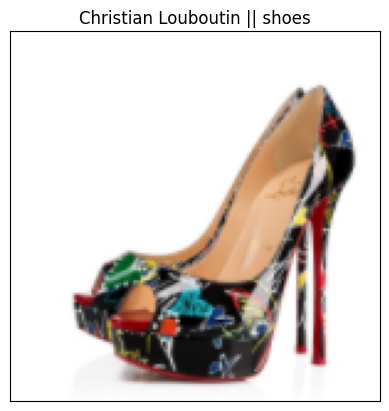

==================== Recommended products: ====================


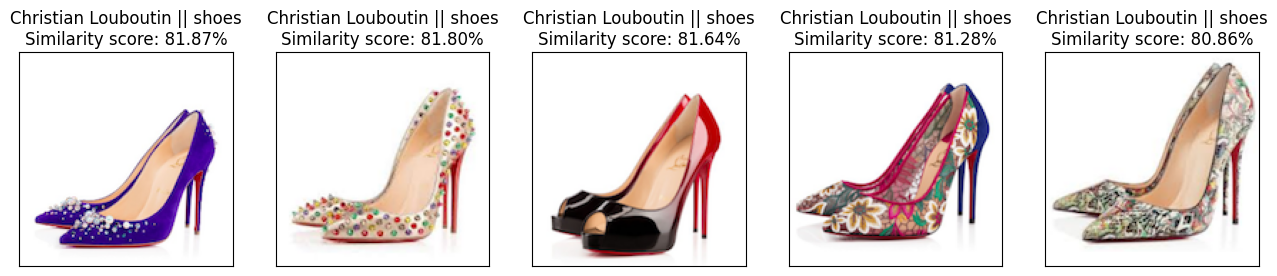

In [57]:
# measure similarity with cosine indexes
retrieve_most_similar_products('0_0_001.png', distance='cosine')

==================== Input product: ====================


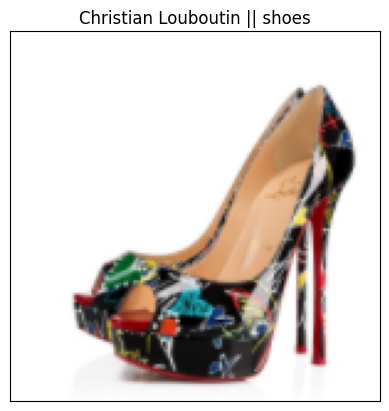

==================== Recommended products: ====================


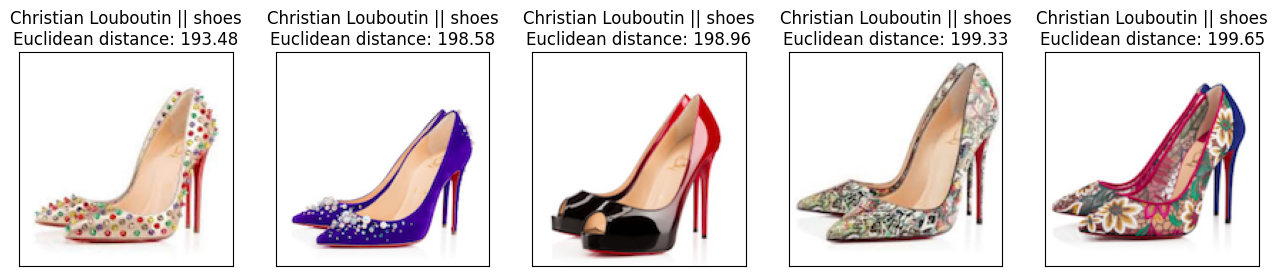

In [58]:
# do the same with Euclidean distances
retrieve_most_similar_products('0_0_001.png', distance='euclidean')

The function returned the exact same images of high heeled shoes for both measures.

==================== Input product: ====================


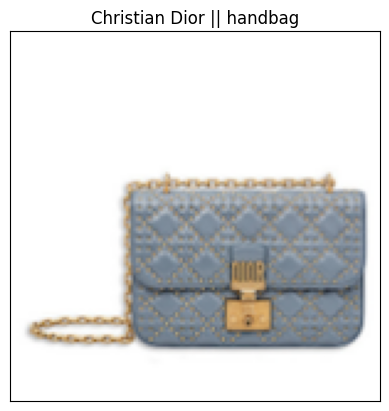

==================== Recommended products: ====================


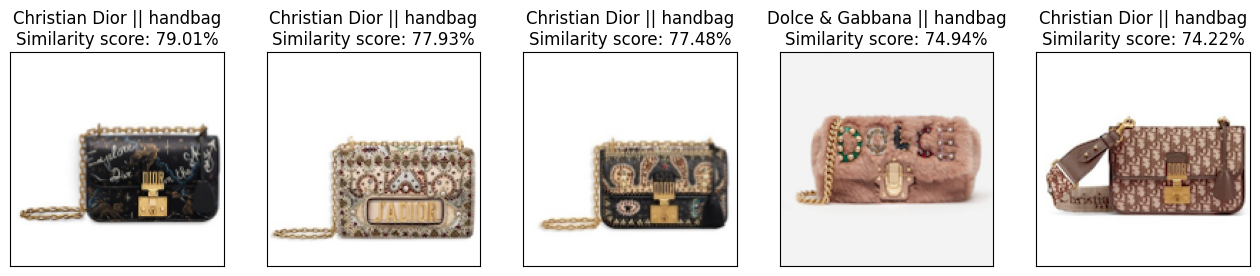

In [59]:
# measure similarity with cosine indexes
retrieve_most_similar_products('4_2_024.png', distance='cosine')

==================== Input product: ====================


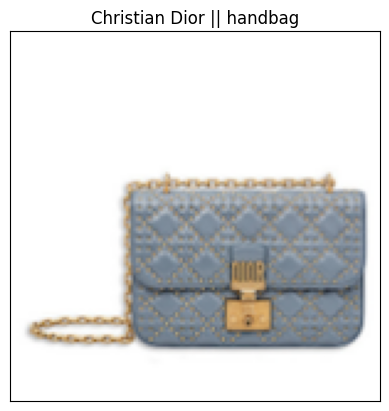

==================== Recommended products: ====================


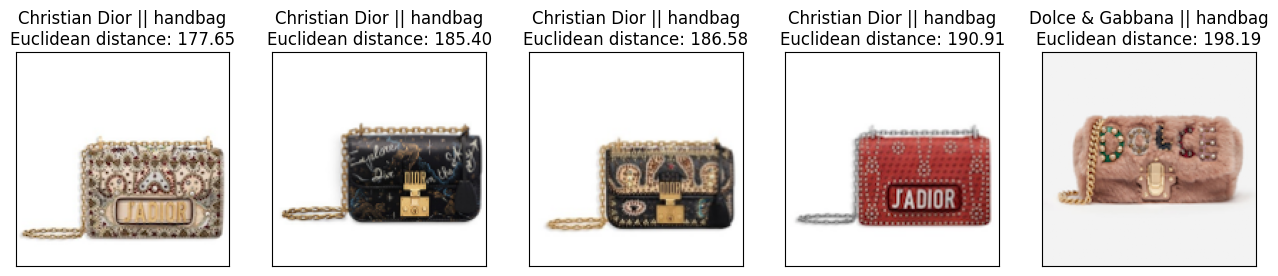

In [60]:
# do the same with Euclidean distances
retrieve_most_similar_products('4_2_024.png', distance='euclidean')

We can observe that the recommendation system works very well at identifying products by its shape. This time it returned items with the same use.

==================== Input product: ====================


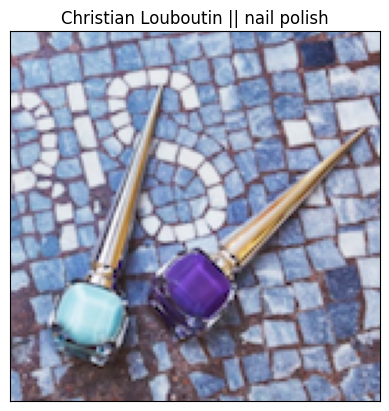

==================== Recommended products: ====================


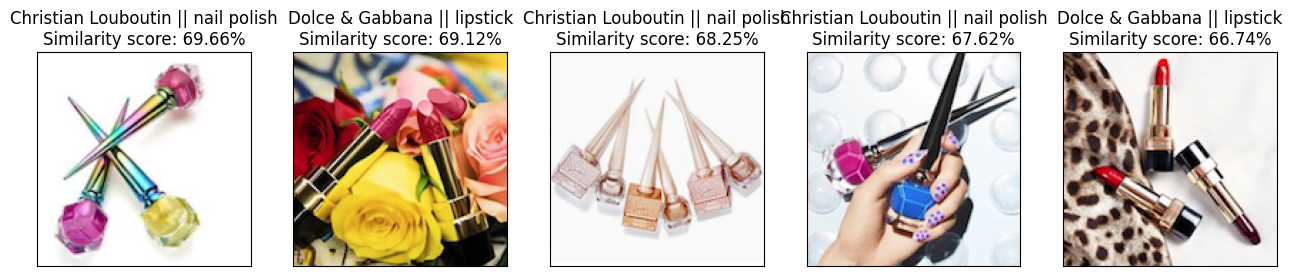

In [61]:
# last image recognition with background
retrieve_most_similar_products('0_3_001.png', distance='cosine')

In this case we ran the engine on a much more different image with background. Object detection is much more challenging and the engine returned two lipsticks aside nail polish, yet most of them still have similar shapes.

### 7. VGG16

We will implement the exact similarity search on VGG16 network.

In [62]:
# retrieve VGG16 and rename
vgg_mod = feature_extractor(name='vgg16')
vgg_mod._name = 'VGG16'

# display the network's architecture
vgg_mod.summary()

# get number of layers in the feature extractor
print('\nNumber of layers:', len(vgg_mod.layers))

553467096/553467096 [==============================] - 10s 0us/step
Model: "VGG16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                           

In [63]:
# extract features with ResNet50
imgs_features = extract_features(vgg_mod)

69/69 [==============================] - 1509s 22s/step
Number of processed images: 2184
Number of extracted features per image: 4096


In [1]:
# measure similarity with cosine indexes
retrieve_most_similar_products('4_2_003.png', distance='cosine')

NameError: ignored

==================== Input product: ====================


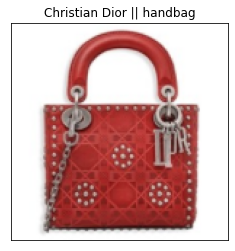

==================== Recommended products: ====================


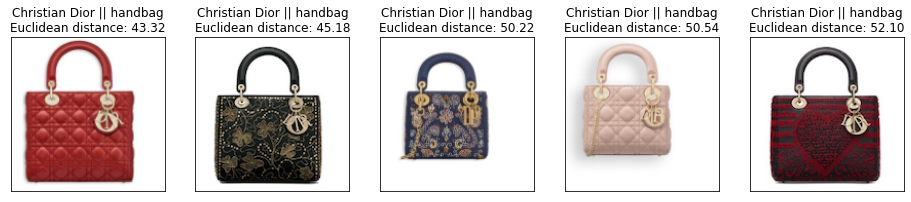

In [ ]:
# do the same with Euclidean distances
retrieve_most_similar_products('4_2_003.png', distance='euclidean')

All items are handbags and there is only one different picture for both metrics.

==================== Input product: ====================


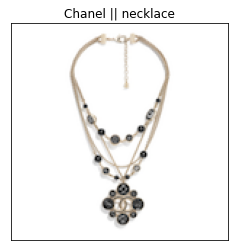

==================== Recommended products: ====================


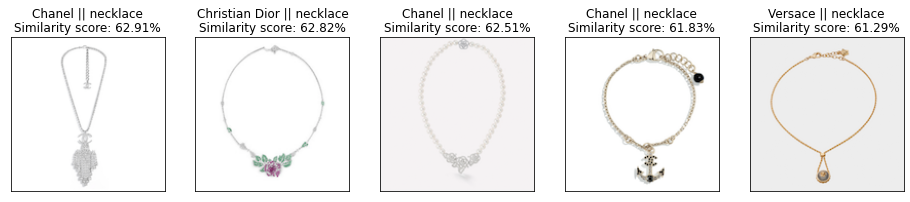

In [ ]:
# measure similarity with cosine indexes
retrieve_most_similar_products('1_4_022.png', distance='cosine')

==================== Input product: ====================


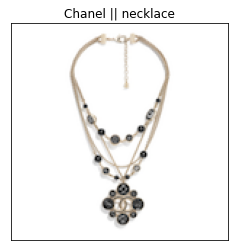

==================== Recommended products: ====================


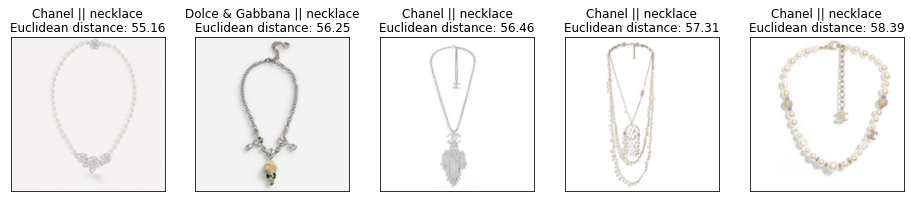

In [ ]:
# do the same with Euclidean distances
retrieve_most_similar_products('1_4_022.png', distance='euclidean')

All objects are necklaces and only two images repeat for both distances. Each necklace has a unique style and design.

==================== Input product: ====================


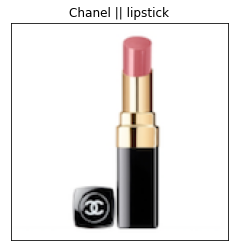

==================== Recommended products: ====================


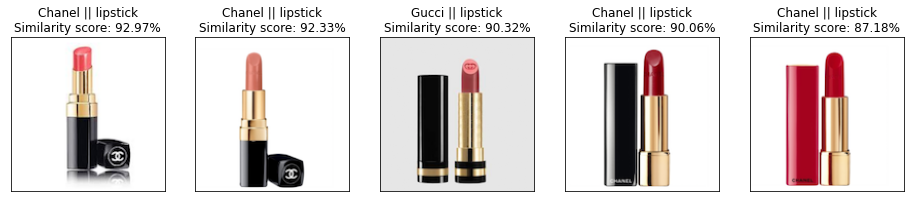

In [ ]:
# last image recognition
retrieve_most_similar_products('1_1_006.png', distance='cosine')

### 8. Conclusions

In this notebook, we discussed about product recommendations and implemented a visual similarity based recommendation engine by utilising available fashion product images. Building a deep learning model using pre-trained convolutional neural networks is an accessible reality using frameworks like <code>Keras</code>, that abstract the user from building complex algorithms or architectures. This allows to rather focus on going directly to the construction of the required models using simple coding structures.

Our recommender engines are based on pre-trained models: ResNet50 and VGG16. The recommender systems are able to find similar products accurately: most of the time the retrieved products have the same purpose and look very similar. They certainly work well in terms of shapes; patterns are not always recognized.

Finally, it would be interesting to research how to transform these engines into a software as a service component.
A user can make a request through a web API by sending an input image and after running our query on our server, we could retrieve the top similar products and return them also through the web interface. This could be incorporated directly into a website using a web framework such as Flask or Django.

**References:**

1. Aurelien Géron, 2019, *Hands-On Machine Learning with Scikit-Learn, Keras, and Tensorflow: Concepts, Tools, and Techniques to Build Intelligent Systems, 2nd Edition*
2. Rui Pedro da Silva Rodrigues Machado, 2017, *Image visual similarity with deep learning: application to a fashion e-commerce company*